In [1]:

import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import os

print(os.listdir('../AIBabySitter/database/'))

['drive-download-20201123T234734Z-001.zip', 'test', 'train', 'val']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=227
IMAGE_HEIGHT=227
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir('../AIBabySitter/database/train/')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'sittingup' or category == 'faceup':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df

,filename,category
0,climb. (1).jpeg,0
1,climb. (10).jpeg,0
2,climb. (11).jpeg,0
3,climb. (12).jpeg,0
4,climb. (13).jpeg,0
...,...,...
253,stand. (5).jpeg,0
254,stand. (6).jpeg,0
255,stand. (7).jpeg,0
256,stand. (8).jpeg,0


<AxesSubplot:>

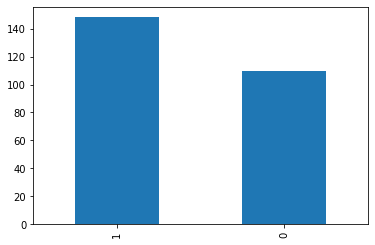

In [5]:
df['category'].value_counts().plot.bar()

faceup. (38).jpeg


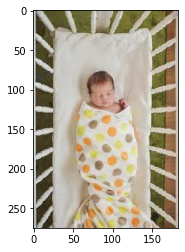

In [6]:
sample = random.choice(filenames)
image = load_img('../AIBabySitter/database/train/'+sample)
plt.imshow(image)
print(sample)

Input: Color images of size 227x227x3. The AlexNet paper mentions the input size of 224×224 but that is a typo in the paper.

Conv-1: The first convolutional layer consists of 96 kernels of size 11×11 applied with a stride of 4 and padding of 0.

MaxPool-1: The maxpool layer following Conv-1 consists of pooling size of 3×3 and stride 2.

Conv-2: The second conv layer consists of 256 kernels of size 5×5 applied with a stride of 1 and padding of 2.

MaxPool-2: The maxpool layer following Conv-2 consists of pooling size of 3×3 and a stride of 2.

Conv-3: The third conv layer consists of 384 kernels of size 3×3 applied with a stride of 1 and padding of 1.

Conv-4: The fourth conv layer has the same structure as the third conv layer. It consists of 384 kernels of size 3×3 applied with a stride of 1 and padding of 1.

Conv-5: The fifth conv layer consists of 256 kernels of size 3×3 applied with a stride of 1 and padding of 1.

MaxPool-3: The maxpool layer following Conv-5 consists of pooling size of 3×3 and a stride of 2.

FC-1: The first fully connected layer has 4096 neurons.

FC-2: The second fully connected layer has 4096 neurons.

FC-3: The third fully connected layer has 1000 neurons.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), 
                 kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
#-----------------------------------------------------------------------------------------

# Max Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid')) 
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
#-----------------------------------------------------------------------------------------

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
#-----------------------------------------------------------------------------------------

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# Passing it to a dense layer which is the Fully Connected layer.
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(IMAGE_WIDTH * IMAGE_HEIGHT * IMAGE_CHANNELS,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())
#-----------------------------------------------------------------------------------------

# Output Layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

# (4) Compile 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [8]:
df["category"] = df["category"].replace({0: 'unsafe', 1: 'safe'}) 

In [9]:
df

,filename,category
0,climb. (1).jpeg,unsafe
1,climb. (10).jpeg,unsafe
2,climb. (11).jpeg,unsafe
3,climb. (12).jpeg,unsafe
4,climb. (13).jpeg,unsafe
...,...,...
253,stand. (5).jpeg,unsafe
254,stand. (6).jpeg,unsafe
255,stand. (7).jpeg,unsafe
256,stand. (8).jpeg,unsafe


In [10]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

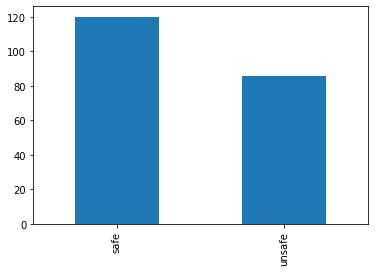

In [11]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

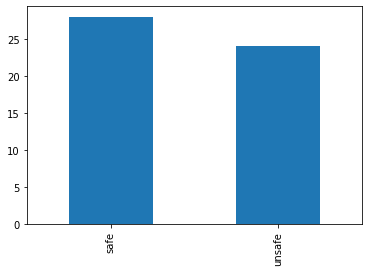

In [12]:
validate_df['category'].value_counts().plot.bar()

In [13]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '../AIBabySitter/database/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 206 validated image filenames belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
   '../AIBabySitter/database/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 52 validated image filenames belonging to 2 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '../AIBabySitter/database/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


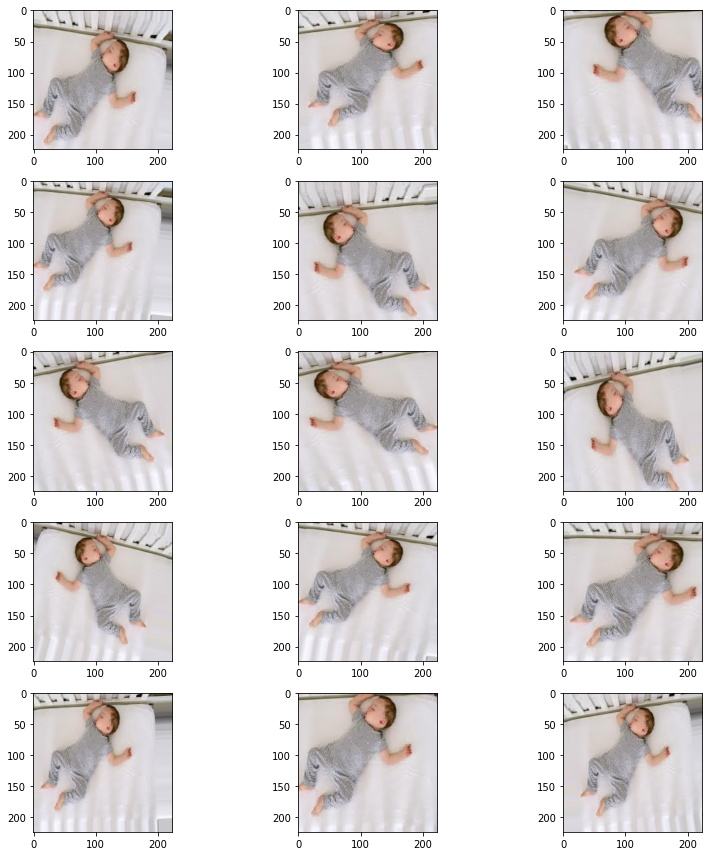

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
epochs = 3 if FAST_RUN else 25
history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    #callbacks = callbacks
)

#model.fit(x, y, batch_size=64, epochs=1, verbose=1, \
#validation_split=0.2, shuffle=True)

Epoch 1/25


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[15,10] labels_size=[15,2]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-18-f495cb7efa4e>:2) ]] [Op:__inference_train_function_3159]

Function call stack:
train_function


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir('../AIBabySitter/database/')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
   '../AIBabySitter/database/', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'safe': 1, 'unsafe': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('../AIBabySitter/database/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()